In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

import sys
import os
import math

import yamlt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import healpy as hp
import pymaster as nmt
import pyccl as ccl

sys.path.append('..')
from experiment import Experiment, show_mcmc_report
from plotting import plot_correlation

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
sns.set(style='ticks')
pd.set_option('mode.chained_assignment', None)

# Parameters

In [4]:
with open('../configs.yml', 'r') as config_file:
    config = yaml.full_load(config_file)
config = config['NVSS']
display(config)

{'lss_survey': 'NVSS',
 'nside': 512,
 'bias': 2.18,
 'scale_bias': False,
 'correlation_symbols': ['gg', 'gk', 'gt'],
 'l_min': 2,
 'ell_lengths': [8, 10, 30, 50],
 'starting_params': {'bias': '(2.18', '0.5)': None},
 'default_params': {'bias': 2.18},
 'n_walkers': 32,
 'max_iterations': 5000,
 'continue_sampling': False}

# Data

In [5]:
experiment = Experiment(config, set_maps=True)

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


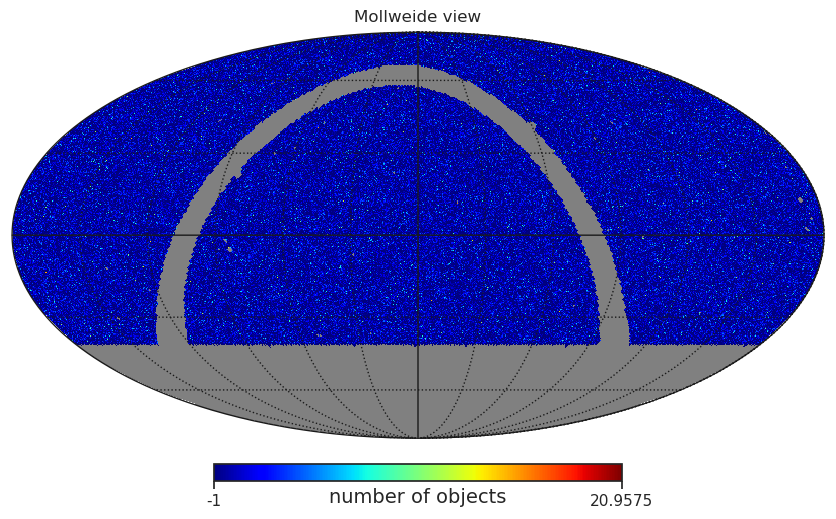

In [7]:
hp.mollview(experiment.processed_maps['g'], cmap='jet', unit='number of objects')
hp.graticule()

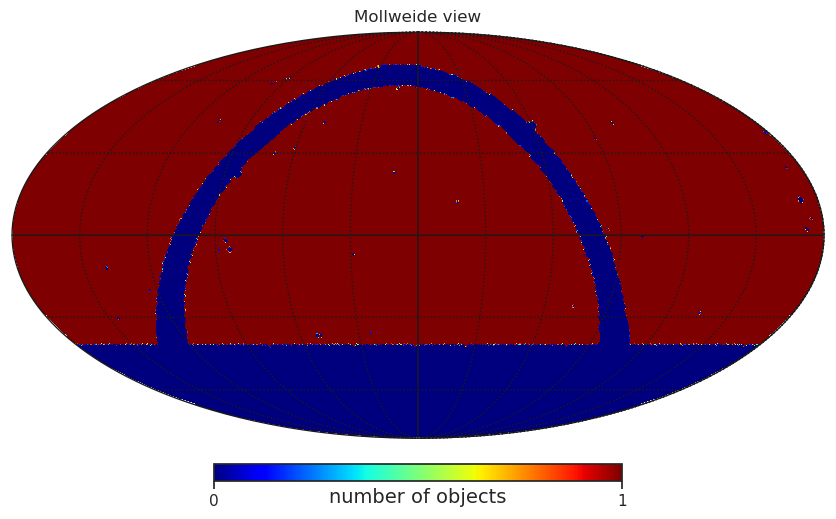

In [8]:
hp.mollview(experiment.masks['g'], cmap='jet', unit='number of objects')
hp.graticule()

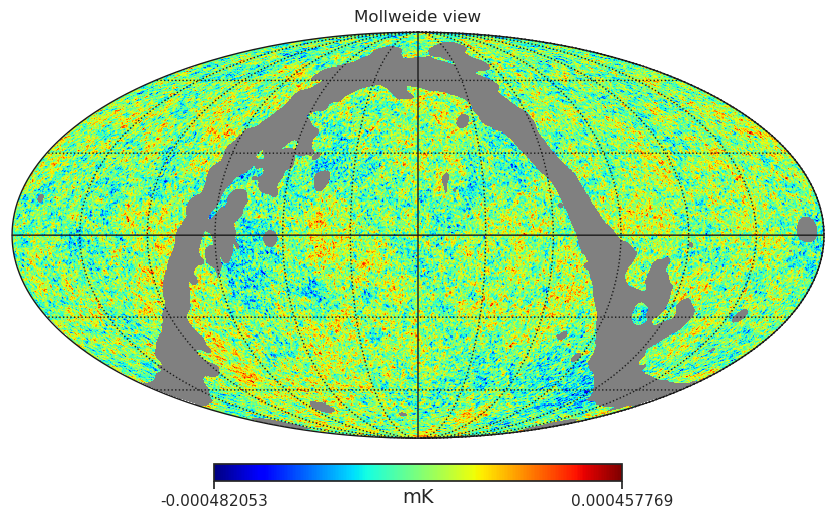

In [9]:
hp.mollview(experiment.processed_maps['t'], cmap='jet', unit='mK')
hp.graticule()

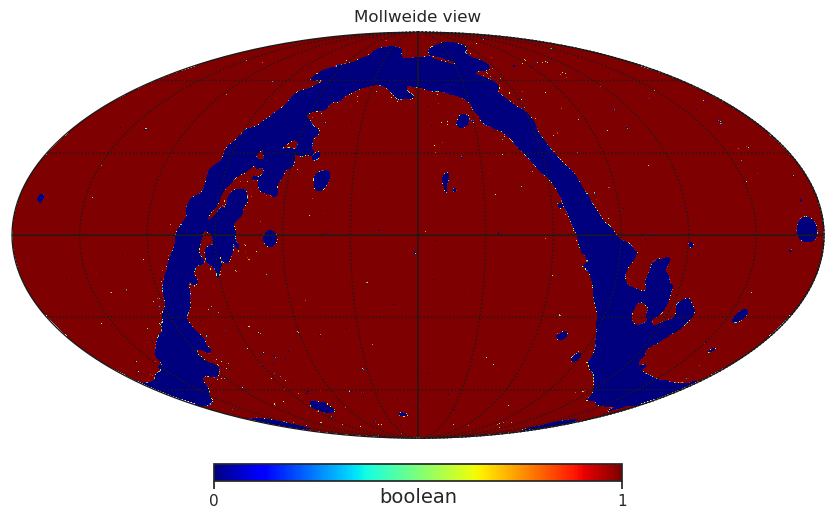

In [10]:
hp.mollview(experiment.masks['t'], cmap='jet', unit='boolean')
hp.graticule()

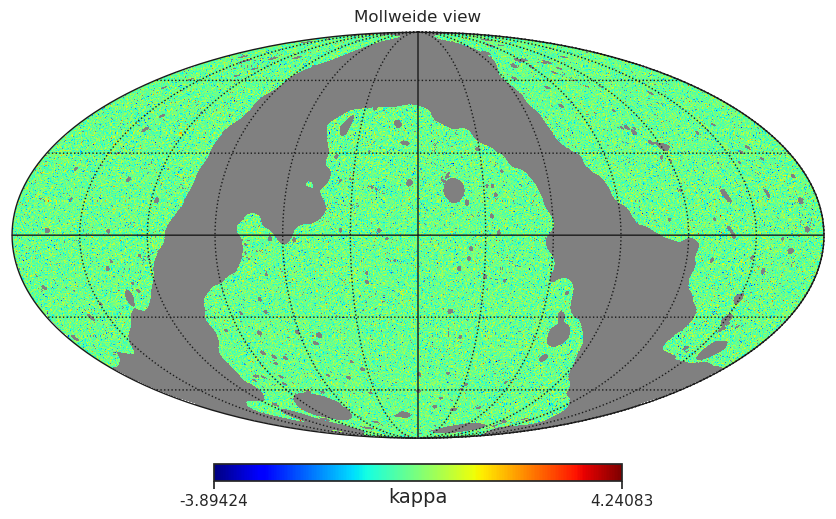

In [11]:
hp.mollview(experiment.processed_maps['k'], cmap='jet', unit='kappa')
hp.graticule()

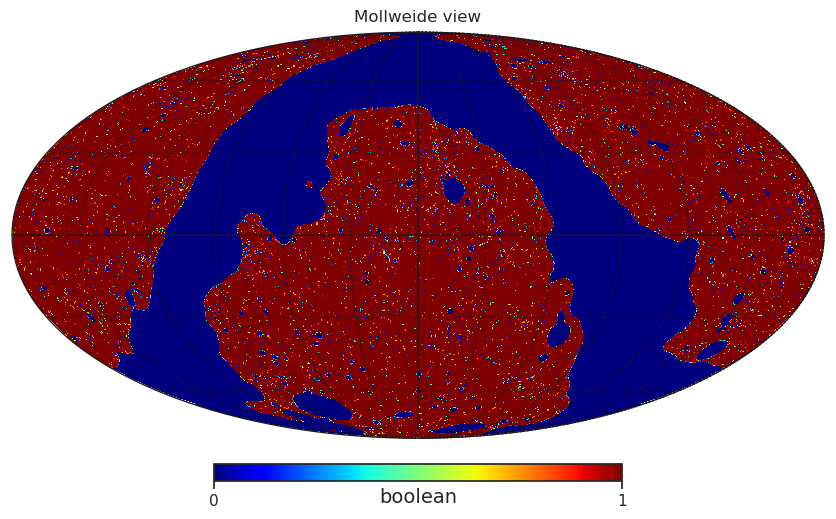

In [12]:
hp.mollview(experiment.masks['k'], cmap='jet', unit='boolean')
hp.graticule()

# Power spectra

In [13]:
experiment.set_correlations()

(0.0765460427498687, 0.6539070167786581)

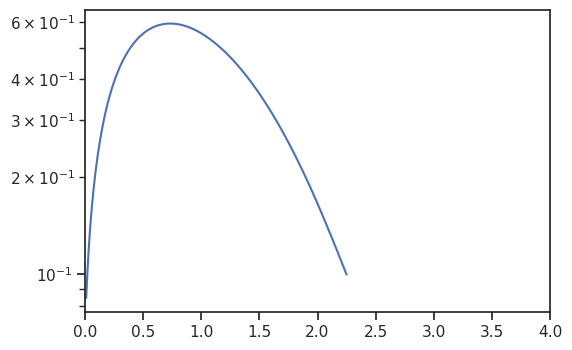

In [14]:
plt.plot(experiment.z_arr, experiment.n_arr / 19.084)
plt.yscale('log')
plt.xscale('linear')
plt.xlim(xmin=0, xmax=4)
plt.ylim(ymin=None, ymax=None)

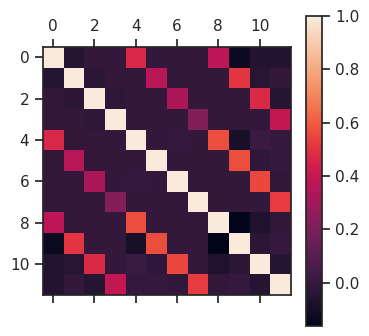

In [15]:
plt.matshow(experiment.inference_correlation)
plt.colorbar()

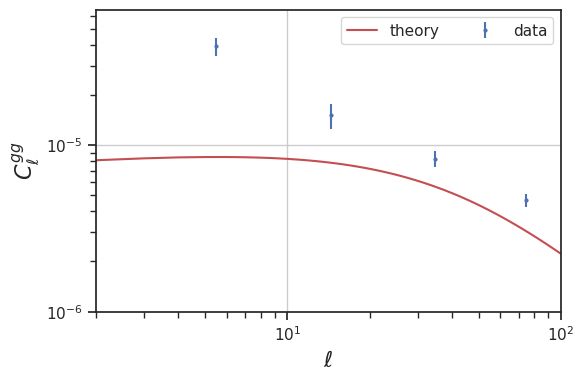

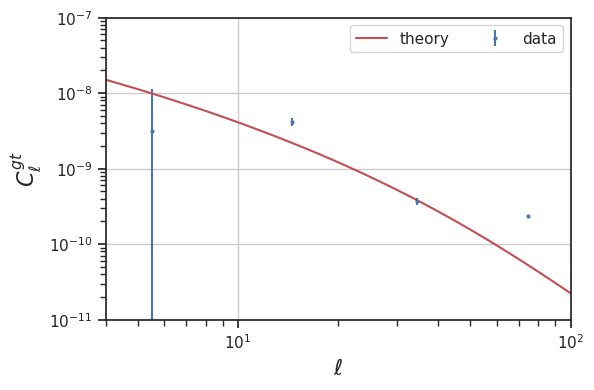

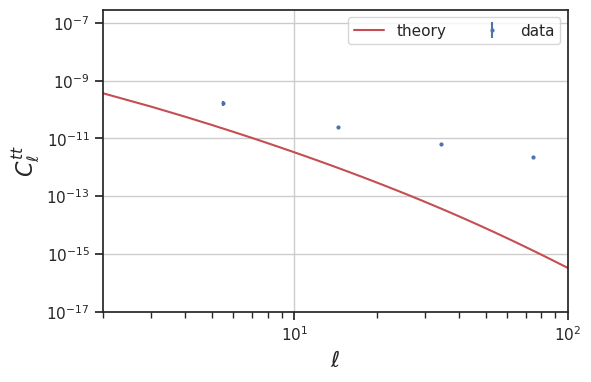

In [16]:
plot_correlation(experiment, 'gg', x_min=2, x_max=100, y_min=1e-6, y_max=None, x_scale='log', y_scale='log')
plot_correlation(experiment, 'gt', x_min=4, x_max=100, y_min=1e-11, y_max=1e-7, x_scale='log', y_scale='log')
plot_correlation(experiment, 'tt', x_min=2, x_max=100, y_min=1e-17, y_max=None, x_scale='log', y_scale='log')